In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import statistics as st
import matplotlib.pyplot as plt
import fa2
import powerlaw

In [2]:
def calc_stats(graph_degrees: nx.Graph):
    """
    Calculate mean, median, mode, min and max of given graph degrees
    
    Returns
    -------
    Namespace
        Namespace with statistics
    """

    class Namespace:
        def __init__(self, **kwargs):
            self.__dict__.update(**kwargs)
        
        def __str__(self):
            return str(self.__dict__)

    degrees = [elem[1] for elem in sorted(graph_degrees, key=lambda x: x[1], reverse=True)]
    return Namespace(
        mean=st.mean(degrees),
        median=st.median(degrees),
        mode=st.mode(degrees),
        min=min(degrees),
        max=max(degrees),
    )

def print_header(title: str):
    """Prints pretty header"""
    print("="*20 + f" {title} " + "="*20 + "\n")

In [3]:
with open('data/data_all.pickle', 'rb') as f:
    data = pickle.load(f)

In [3]:
from datautils import datautils

loader = datautils.Loader()
loader.load("data/characters/")
data = loader.to_dataframe()
loader.drop()

In [5]:
data['Human'] = np.nan
data.loc[data.Species == 'Human', 'Human'] = 'Human'
data.loc[data.Species != 'Human', 'Human'] = 'Other'

In [7]:


# initialize universe directional graph
Universe = nx.DiGraph()
for _, character in data.iterrows():
    # add node with metadata for each character
    Universe.add_node(character.Name, human = character.Human, gender = character.Gender, species = character.Species, home = character.Homeworld)
    for connection in character.Crosslinks:
        if connection in data.Name.values:
            # add edge between character and its connection if it's not a self loop
            if connection != character.Name:
                Universe.add_edge(character.Name, connection)

In [8]:
print(f"Number of nodes: {len(Universe.nodes)}")
print(f"Number of links: {len(Universe.edges)}")

Number of nodes: 29435
Number of links: 91976


In [8]:
# save graph as an edgelist
nx.write_edgelist(Universe, "graph/universe.edgelist")

In [9]:
print_header("Universe stats")
in_stats = calc_stats(Universe.in_degree())
out_stats = calc_stats(Universe.out_degree())
print(f"In degree: {in_stats}")
print(f"Out degree: {out_stats}")

==================== Universe stats ====================

In degree: {'mean': 0.6850568208610365, 'median': 0, 'mode': 0, 'min': 0, 'max': 239}
Out degree: {'mean': 0.6850568208610365, 'median': 0, 'mode': 0, 'min': 0, 'max': 106}


In [10]:
in_degrees = [degree[1] for degree in Universe.in_degree() if degree[1] > 0]
in_degree_alpha = powerlaw.Fit(in_degrees).alpha
print(f"In degree slope: {in_degree_alpha:.2f}")

Calculating best minimal value for power law fit
In degree slope: 2.98


In [11]:
YELLOW = "#fce700"
BLUE = "#00d7fc"
GRAY = "#000000"

largest_component = sorted(nx.weakly_connected_components(Universe), key=len, reverse=True)[0]
Undirected_universe_lc = Universe.subgraph(largest_component).to_undirected()
# set node colors
node_color = ["#e6253e" if Undirected_universe_lc.nodes[node]["human"] == "Human" else "#000000" for node in Undirected_universe_lc.nodes]
# set node size
node_size = [Undirected_universe_lc.degree(node)//3 for node in Undirected_universe_lc.nodes]
# edge color
edge_color = []
for node1, node2 in Undirected_universe_lc.edges():
    universe1 = Undirected_universe_lc.nodes[node1]["human"]
    universe2 = Undirected_universe_lc.nodes[node2]["human"]
    if universe1 == universe2:
        if universe1 == "Human":
            edge_color.append(YELLOW)
        else:
            edge_color.append(BLUE)
    else:
        edge_color.append(GRAY)


In [12]:
# use Force Atlas 2
if not os.path.exists("data/"):
    os.makedirs("data")

FA_POSITIONS = "data/positions.pickle"
# load pickle with pre-calculated positions if present
if os.path.exists(FA_POSITIONS):
    with open(FA_POSITIONS, "rb") as rbfile:
        positions = pickle.load(rbfile)
else:
    positions = fa2.ForceAtlas2().forceatlas2_networkx_layout(Undirected_universe_lc, pos=None, iterations=2000)
    # save to pickle for later use
    with open(FA_POSITIONS, "wb") as wbfile:
        pickle.dump(positions, wbfile)

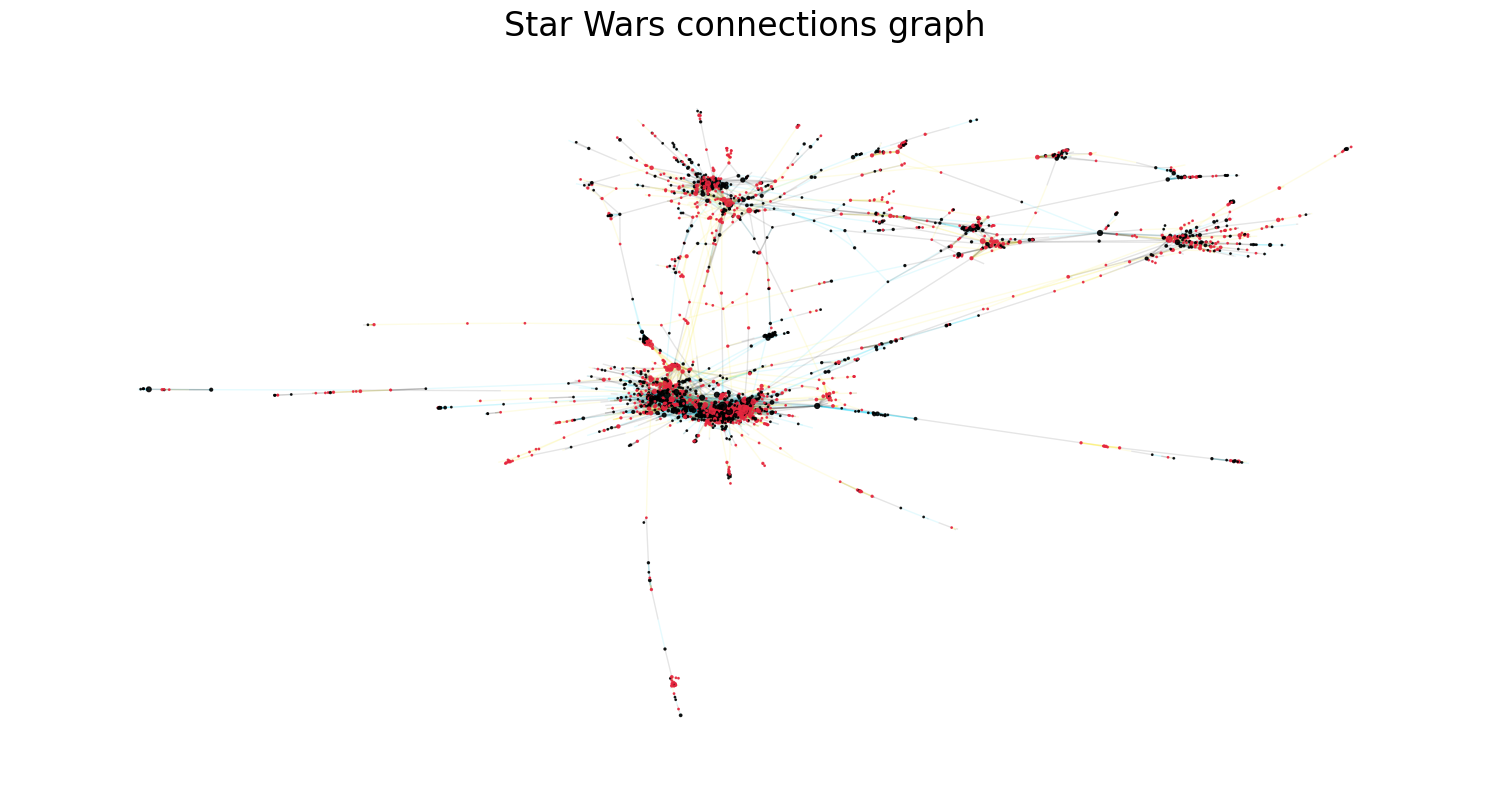

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
nx.draw_networkx_nodes(Undirected_universe_lc, positions, node_color=node_color, node_size=node_size, alpha=0.85, ax=ax)
nx.draw_networkx_edges(Undirected_universe_lc, positions, edge_color=edge_color, alpha=0.1, ax=ax)
ax.set_title("Star Wars connections graph", size=24)
ax.axis("off")
# plt.show()
plt.tight_layout()
plt.savefig('starwars_network.png')